## Drone-Network Design Queueing Model

This notebook uses the model and data from the following studies:

- Lejeune M.A., Margot F. 2022. Drone-Network Design for Out-of-Hospital Cardiac Arrests. Working Paper, submitted.
- Custodio.J., Lejeune M.A. 2022. Spatiotemporal Data Set of Out-of-Hospital Cardiac Arrests. *INFORMS Journal on Computing* 34 (1), 4-10.

The data and its full description can be found here:
https://github.com/INFORMSJoC/2020.1022

The example reads from the VBOHCAR Excel file that contains data for:
- out-of-hospital cardiac arrest (OHCA) incidents
- potential base stations for drones
- pairwise incident/base station (Harversine) distances

The MILP reformulation is modeled in gurobipy and solved using the Gurobi Optimizer. 

To begin, we import the necessary packages for data intake, modeling, and visualization. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from datetime import datetime
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

### Input Data Processing and Visualization
We use pandas to quickly read in the required sheets from Excel. There is a small amount of data prep needed, where some duplicate events need to be removed and text should be cleaned. For reference, an incident location encompasses a street block. 

In [2]:
# read incident and base station data
ohca_read = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/drone_network_1_2/OHCAs.csv', index_col=0)
stations_df = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/drone_network_1_2/BaseStations.csv', index_col=0)  

# some bases are different types (e.g. fire and police), add the type to create a different base name
stations_df['Base'] = stations_df.Street + ' ' + stations_df.Type

# read data on indicent-base distance
dist_read = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/drone_network_1_2/Base_to_OHCA_distance.csv', index_col=[0,1])

The above reads the complete data set, including all OHCAs, base stations, and respective distances. We will subset indicent data by the last three months of data to get an instance that will solve quickly. 

In [3]:
# select a subset of OHCAs so the model can be solved in this notebook (if you have a full license then you can use all incidents)
start_date = '2019-05-31' 
end_date = '2019-06-30'
n_days =  (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days
ohca_df = ohca_read[(ohca_read.ReceivedTime >= start_date) & (ohca_read.ReceivedTime <= end_date)]
dist = dist_read.loc[dist_read.index.get_level_values(1).isin(ohca_df.index)]
print(f"Number of days: {n_days} \nNumber of OHCAs: {ohca_df.shape[0]}")

Number of days: 30 
Number of OHCAs: 69


Next, we create scatterplots to visualize the OHCA locations and stations.

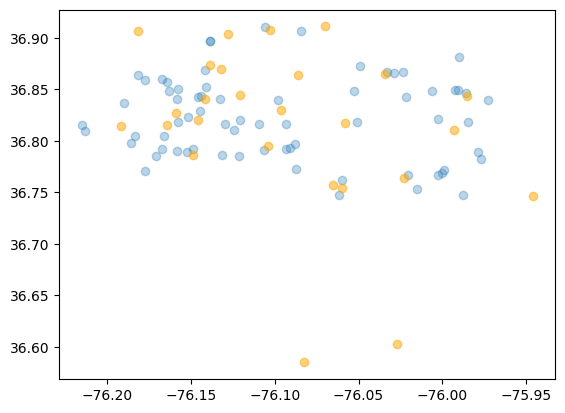

In [4]:
plt.scatter(data = ohca_df, x = 'Longitude', y = 'Latitude', alpha = .3)
plt.scatter(data = stations_df, x = 'Longitude', y = 'Latitude', alpha = 0.5, c = 'orange')

In [5]:
# create a base / OHCA data frame using the location names
df = dist.join(ohca_df[['Incident_Location']])
df = df.join(stations_df['Base'])
df = df.drop_duplicates()
df = df.set_index(['Incident_Location','Base'])

### MILP Model

#### Parameter Calculation
We assume that drones at each station will have the same speed and mainenace times. The total time it takes a drone to service an OHCA is travel time (to and back from the OHCA location) plus maintenance time. 

In [6]:
# limit number of drones
n_drones = 15
# assume a 100 km/hr drone speed (about 38 mph) for each drone
speed = 100
# average time to prep, dispatch, clean, perform maintenance etc. a drone is 25 min, converted to hours
maintenance = 25/60
# calculate average service time from i to j (converting to meters to kilometers)
distance = df['Harversine Distance (meters)']
service_time = maintenance + 2*0.001*distance/speed
service_time = service_time.rename('service_time')

Next, we use the MLE for the arrival rate of an OHCA to each location $i$ as $\lambda_{i} = N_i/t$, where $N_i$ is the number of incidents over time $t$. 

In [7]:
incident_count = ohca_df.Incident_Location.value_counts()
# arrival rate is in hours to match drone speed units
arrival_rate = round(incident_count/(24*n_days),6) 

I = df.index.get_level_values(0).unique()
J = df.index.get_level_values(1).unique()

# make list of each OHCA / base pair
base_to_ohca = df.index.tolist()

# print DAILY arrival rates for each location 
24*arrival_rate.sort_values(ascending = False)

Incident_Location
1700 PLEASURE HOUSE RD    0.066672
1800 DOLINA DR            0.033336
3600 BONNEY RD            0.033336
3400 CHAMPLAIN LA         0.033336
2400 LAUREL COVE DR       0.033336
                            ...   
4400 SANIBEL CI           0.033336
1600 OLD DONATION PKWY    0.033336
600 FLEET DR              0.033336
200 ARAGONA BL            0.033336
1200 GENERAL ST           0.033336
Name: count, Length: 68, dtype: float64

#### Base Formualtion (BF) Variables and Constraints

We start to build the MILP model by introducing binary variables $x_{j}$ and $y_{i,j}$ which will be 1 if location $j$ is chosen and services OHCA $i$. We start with constraints typical to facility location problem. 
\begin{align}
&y_{i,j} \le x_j \\
&\sum_{j \in J} x_j \le p \\
&\sum_{i \in I_{j}} y_{i,j} = 1 \\
\end{align}

Next, we require each queue meet stability requirements:
\begin{align}
\sum_{i \in I_{j}}\lambda_{i}s_{i,j}y_{i,j} \le 1
\end{align}

Below are these constaints written in gurobipy.

In [8]:
m = gp.Model('drone_network')

x = m.addVars(J, vtype=GRB.BINARY, name='x')            #selection
y = m.addVars(base_to_ohca, vtype=GRB.BINARY, name='y') #assignment

m.addConstrs((y[(i,j)] <= x[j] for i,j in base_to_ohca), name='select')
m.addConstr(x.sum() <= n_drones, name = 'drone_limit')
m.addConstrs((y.sum(i,'*') == 1 for i in I), name = 'ohca');
m.addConstrs(((gp.quicksum(arrival_rate[i]*service_time[i,j]*y[(i,j)] for i in I) <= 1) for j in J), name='stability');

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-29


#### Reformulated MILP: Auxilary Variables, Constraints, and Objective Function
The objective for the original formulation is to minimize the average expected response time of the drone network. 
\begin{align}
\text{min}\space \frac{1}{\sum_{k \in I}\lambda_k} \sum_{i \in I} \sum_{j \in J_{i}} \left(\frac{\lambda_iy_{i,j} \sum_{k \in I}\lambda_ky_{k,j}s^{2}_{k,j} }{2[1-\sum_{k \in I}\lambda_ky_{k,j}s_{k,j}]} + \frac{d_{i,j}\lambda_iy_{i,j}}{v_j}\right)
\end{align}

The objective function contains factional and bilinear terms but can be reformualted in such a way that these terms are removed and linearized, creating a MILP. To do this, Linking variables need to be introduced to create the reformulation.

\begin{align}
&V_j = \sum_{i \in I_{j}} \lambda_is^{2}_{i,j}y_{i,j} + \sum_{i \in I_{j}} \lambda_is_{i,j}y_{i,j} \\
&\nu_{i,j} \ge 0 \\
&\nu_{i,j} \ge \overline{V}(y_{i,j}-1) + V_j \\
&\nu_{i,j} \le \overline{V}y_{i,j} \\
&\nu_{i,j} \le V_j \\
\end{align}

The objective function now is:
\begin{align}
\text{min}\space \sum_{i \in I} \sum_{j \in J_{i}} \left(\frac{\nu_{i,j}}{2} + \frac{d_{i,j}y_{i,j}}{v_j}\right)\frac{\lambda_i}{\sum_{k \in I}\lambda_k}
\end{align}

In [9]:
# Auxilary variables and constraints for R-MILP
Vbar = 2*service_time.sum()
V = m.addVars(J, ub = Vbar, name = 'V')
nu = m.addVars(base_to_ohca, name='nu')

m.addConstrs((V[j] == gp.quicksum(arrival_rate[i]*service_time[i,j]**2*y[i,j] for i in I) + gp.quicksum(arrival_rate[i]*service_time[i,j]*nu[i,j] for i in I) for j in J), name = 'aux0')
m.addConstrs((nu[i,j] <= V[j] for i, j in base_to_ohca), name = 'aux1')
m.addConstrs((nu[i,j] <= Vbar*y[i,j] for i, j in base_to_ohca), name = 'aux2')
m.addConstrs((nu[i,j] >= Vbar*(y[i,j]-1) + V[j] for i, j in base_to_ohca), name = 'aux3')

# for ease in setting the objective there is a bit a simplification
L = arrival_rate.sum()
m.setObjective((1/L)*(gp.quicksum(0.5*arrival_rate[i]*nu[(i,j)] + (arrival_rate[i]*distance[i,j]/speed)*y[(i,j)] for i, j in base_to_ohca)));

Run the optimization:

In [10]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7193 rows, 3588 columns and 23036 nonzeros
Model fingerprint: 0x710d5dd6
Variable types: 1794 continuous, 1794 integer (1794 binary)
Coefficient statistics:
  Matrix range     [2e-04, 2e+03]
  Objective range  [7e-03, 1e+01]
  Bounds range     [1e+00, 2e+03]
  RHS range        [1e+00, 2e+03]
Presolve removed 26 rows and 0 columns
Presolve time: 0.17s
Presolved: 7167 rows, 3588 columns, 23036 nonzeros
Variable types: 1794 continuous, 1794 integer (1794 binary)

Root relaxation: objective 1.621986e+01, 197 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   16.21986    0    2          -   16.219

#### Visualize the Solution Network

Use `getAttr` in gurobipy to quickly get the $x$ and $y$ decision variable values.

In [11]:
# recover the bases used in the optimal solution
sol_x = pd.Series(m.getAttr('X',x))
bases_selected = sol_x[sol_x > 0.5]
bases_selected

1468 NIMMO PKWY Fire Station            1.0
5656 PROVIDENCE RD Fire Station         1.0
800 VIRGINIA BEACH BLVD Fire Station    1.0
949 S BIRDNECK RD Fire Station          1.0
3608 S PLAZA TRAIL Fire Station         1.0
1601 LYNNHAVEN PKWY Fire Station        1.0
4196 PLEASANT VALLEY RD Fire Station    1.0
4672 HAYGOOD RD Fire Station            1.0
600 CENTRAL DR Fire Station             1.0
2641 PRINCESS ANNE RD Fire Station      1.0
4817 COLUMBUS ST Fire Station           1.0
1201 BAYNE DR Fire Station              1.0
3769 E. STRATFORD ROAD Rescue Squad     1.0
2211 GREENWELL ROAD Rescue Squad        1.0
5145 RURITAN COURT Rescue Squad         1.0
dtype: float64

Now export the assignment variables and create a dataframe with the coordinates for each final indicent/base pair

In [12]:
# recover the assignment variable
sol_y = pd.Series(m.getAttr('X',y))
sol_y.name = 'Assignments'
sol_y.index.names = ['Incident_Location','Base']
assignment = sol_y[sol_y > 0.5].to_frame()
assignment = pd.merge(assignment.reset_index()[['Incident_Location','Base']], ohca_df[['Incident_Location','Latitude','Longitude']])
assignment.rename(columns = {'Latitude':'Inc_Latitude', 'Longitude': 'Inc_Longitude'}, inplace = True)
assignment = pd.merge(assignment, stations_df[['Base','Latitude','Longitude']])
assignment.rename(columns = {'Latitude':'Base_Latitude', 'Longitude': 'Base_Longitude'}, inplace = True)

We can now visualize the solution by finding the coordinates for each assignment pair and creating a plot with the incidents and stations to visualize the final network. The light orange points are stations that were not selected.

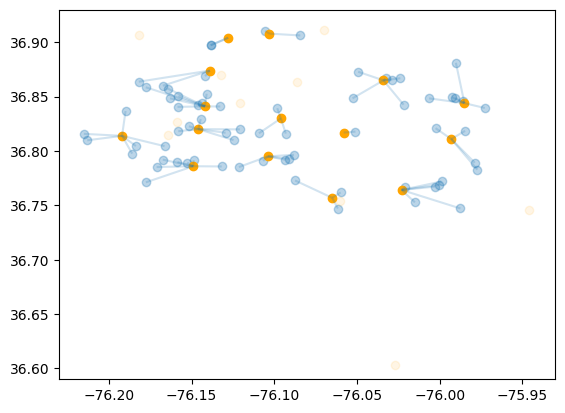

In [13]:
coords = []
for r in range(assignment.shape[0]):
    coords.append([(assignment.Base_Longitude[r],assignment.Base_Latitude[r]),(assignment.Inc_Longitude[r],assignment.Inc_Latitude[r])])
# plot the line segments, indicent points, and base station points of the final network
fig, ax = plt.subplots()
ax.set_xlim(-76.23, -75.93)
ax.set_ylim(36.59, 36.93)
lc = mc.LineCollection(coords, alpha = .2)
ax.add_collection(lc)
plt.scatter(data = ohca_df, x = 'Longitude', y = 'Latitude', alpha = .3)
plt.scatter(data = stations_df[stations_df['Base'].isin(bases_selected.index.tolist())], x = 'Longitude', y = 'Latitude', alpha = 1, c = 'orange') 
plt.scatter(data = stations_df[~stations_df['Base'].isin(bases_selected.index.tolist())], x = 'Longitude', y = 'Latitude', alpha = 0.1, c = 'orange') 
plt.show()